# Generating the Mandelbrot Set 

### Group F Members: Maksymilian Kwasnik, Finlay Douglas, Jakub Trybek

Rendering Mandelbrot set fractals through a hardware implemented algorithm, AXI Lite and python on Jupyter Notebook in order to interface with the design. This notebook will explain how to generate the set, using our IP Core which has been developed throughout this project.

Firstly, the overlay class is imported from the pynq library as shown below. 

In [1]:
from pynq import Overlay

The overlay now needs to be programmed onto the PYNQ-Z2 board, the file is also parsed to understand the contents of the overlay.

In [2]:
ol = Overlay("mandel_wrapper.bit")

The next line prompts a popup from a file which reports the information regarding the overlay, identifying the IP being used.

In [3]:
ol?

The IP is then assigned a more user friendly alias for future coding convenience.

In [4]:
mandHW = ol.mandelbrot_0

# System Generator Hardware

The following images show the different elements of hardware involved in the implementation.

First, the full block diagram can be seen below. It is made up of 2 key elements: the Mandelbrot algorithm, and the magnitude approximation.

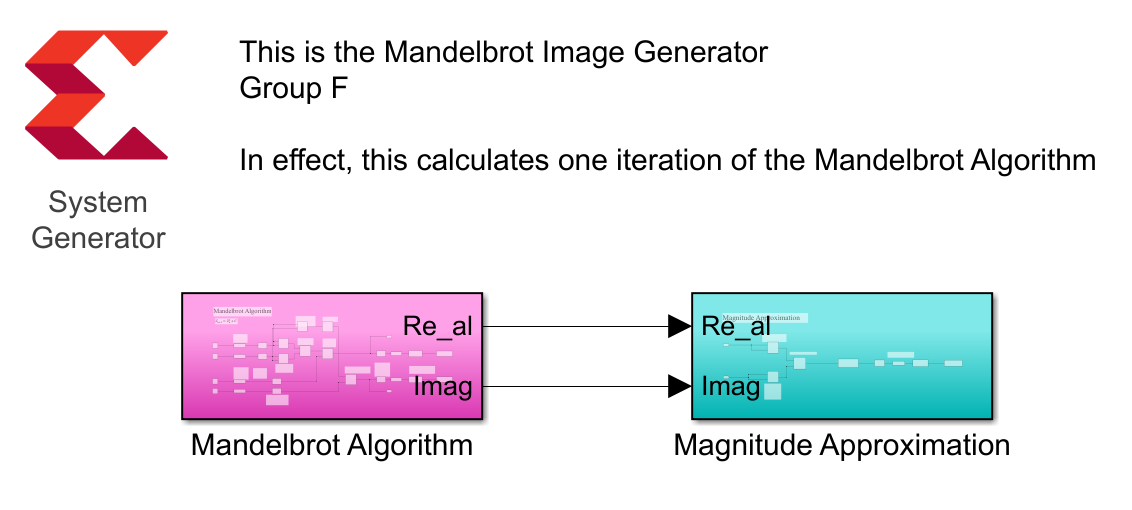

The Mandelbrot Algorithm block is composed as follows. A complex number C is input and one iteration of the algorithm is executed with the complex number Z initially set to 0 +0i. This means the first output of the algorithm is the initial complex input. 

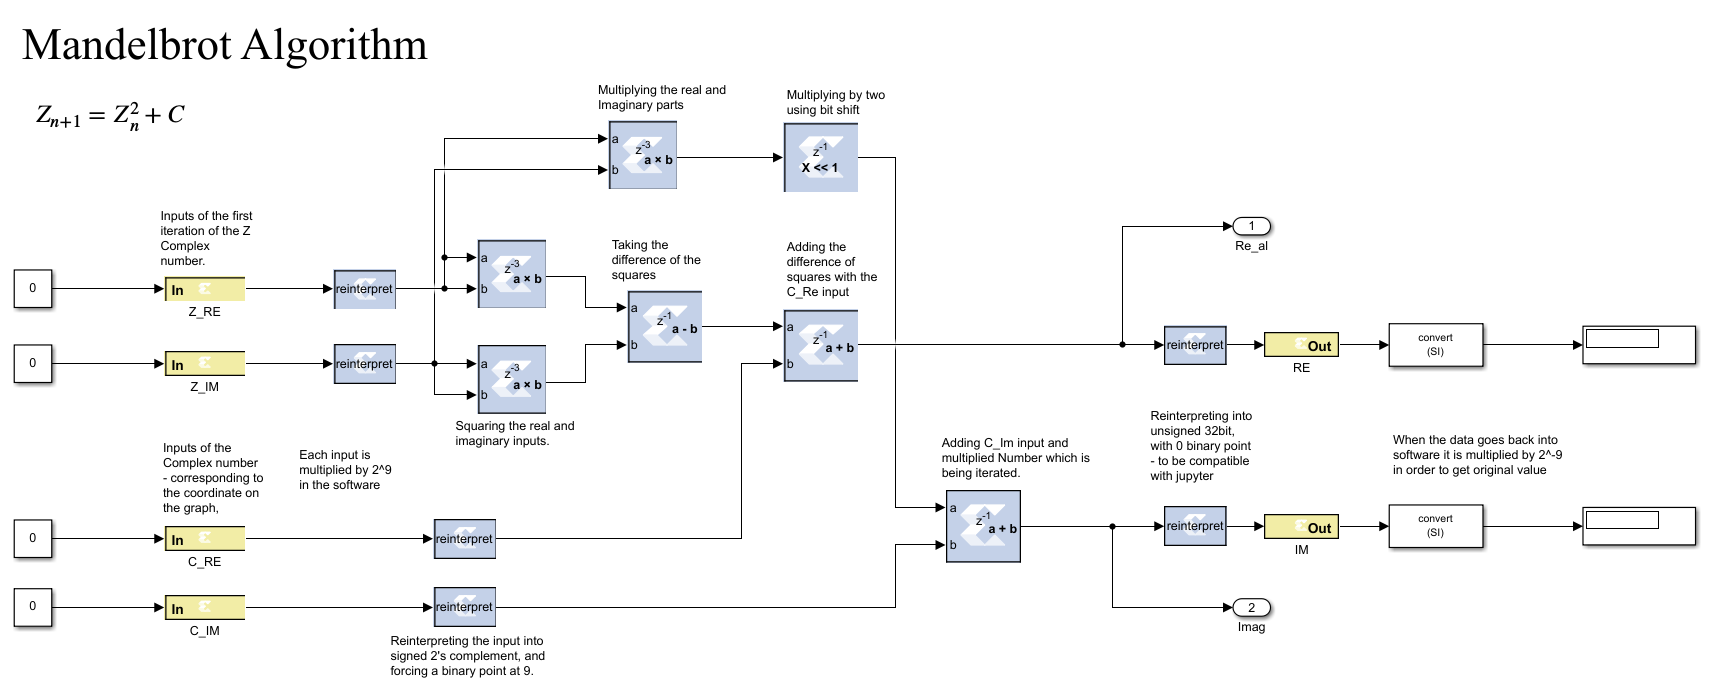

The Magnitude Approximation can be seen below. It operates by taking in the real and imaginary parts of a complex number separately, squaring each component, adding the squared components, and then passing the result into a subsystem which performs the Newton Method of approximating a square root.
The result from this subsytem is passed as an output of magnitude.

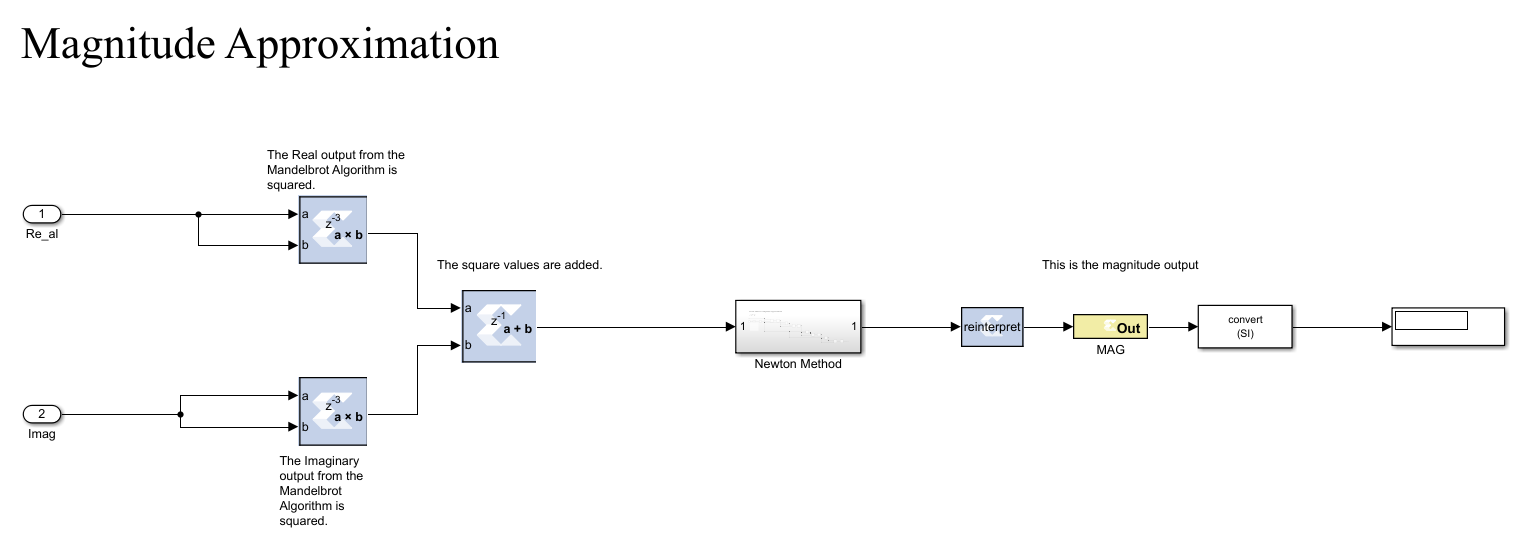

A block diagram of the Newton Method can be seen below. It takes an initial approximation of the final answer (square root) which is set to 1 for the most efficient execution of this algorithm. The closer the initial approximation is the less iterations it takes to arrive at the correct answer to a degree of decimal point accuracy. This algorithm loop is repeated 4 times as it gives an accurate approximation of the square root for the mean range of values being passed through the system.

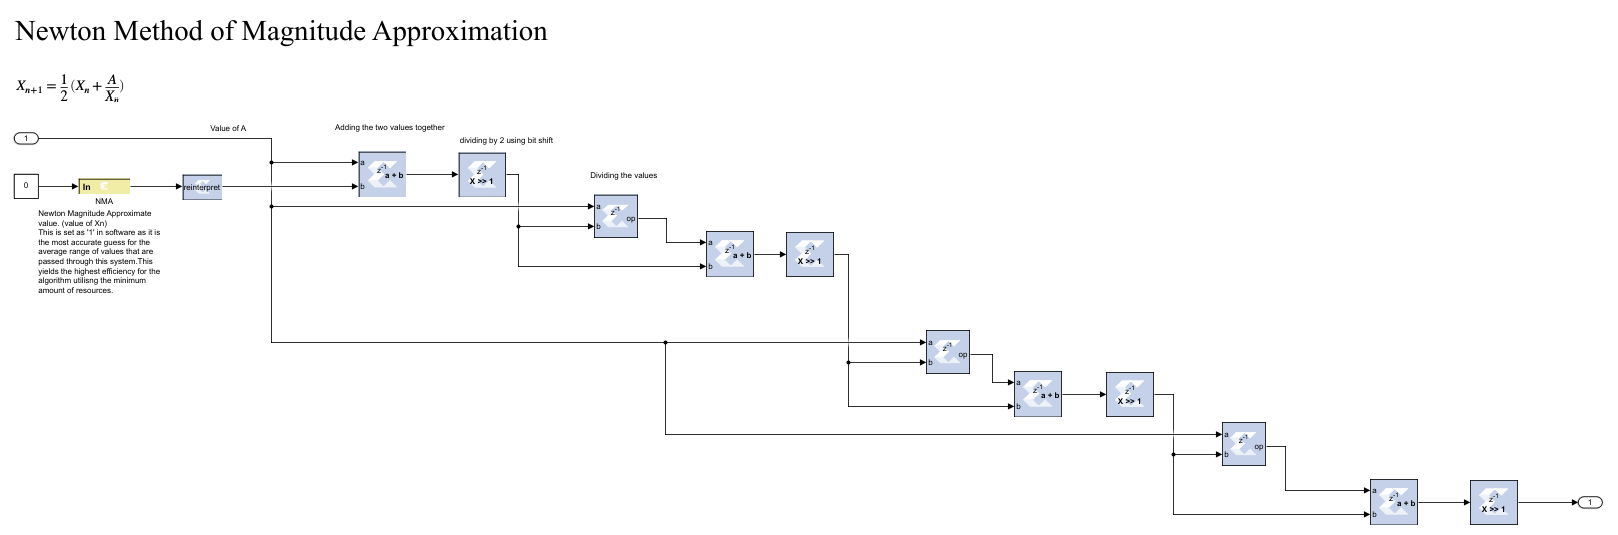

# Code for Generating Mandelbrot Set Images

The code for interacting with the hardware IP and generating Mandelbrot set images is shown in the following section. First, the relevant numpy classes were imported from the numpy library and the necessary functions were imported from pyplot in the matplotlib library.

In [5]:
import numpy as np
from numpy import zeros, linspace
from matplotlib.pyplot import figure, imshow, xlabel, ylabel, colorbar, show
import ipywidgets as widgets
from ipywidgets import TwoByTwoLayout

A short function to convert a value to signed is required since Python cannot read negative values in from the pynq board.

In [6]:
def to_signed(val,b):
    signedVal = val-(2**b)*int(str((val)>>b-1))
    return signedVal

The functions required to generate mandelbrot set images are all shown in the following section.

## Mandelbrot function

This function defines the algorithm which decides if a location on the complex plane is within the mandelbrot set.

It runs the algorithm:

        Zn+1 = Zn^2 + c
        
on each location in the plane passed into the function.

The value either escapes the mandelbrot set before reaching the defined maximum number of iterations (returning the iteration during which the point escaped), or it reaches the maximum number of iterations without escaping (returning the maximum value).

In the case of our project, the algorithm has been implemented in system generator and loaded onto the PYNQ-Z2 board in order to accelerate the process. The IP's alias 'mandHW' is used repeatedly to write and read data to and from the board.

In [7]:
def mandelbrot(CRe, CIm, max):
    ZRe = 0
    ZIm = 0
    mag = 0
    NMA = 1
    
    for i in range(max):
        if (CRe == 0 and CIm == 0):
            return max
        
        mandHW.write(0x08,int((CRe)*(2**9)))
        mandHW.write(0x0C,int((CIm)*(2**9)))
        mandHW.write(0x00,int((ZRe)*(2**9)))
        mandHW.write(0x04,int((ZIm)*(2**9)))
        mandHW.write(0x10,int((NMA)*(2**9)))
        ZRe = to_signed(int(mandHW.read(0x1C)),32)*(2**-9)
        ZIm = to_signed(int(mandHW.read(0x18)),32)*(2**-9)
        mag = mandHW.read(0x14)*(2**-9)
        
        if mag >= 2:
            return i
        
    return max

## Generate_Mandelbrot function

This function splits the complex plane into a grid of X by Y positions, where X and Y are the lengths defined in the resolution variable.

It then runs the mandelbrot function on every existing coordinate within this grid, defining a value of iterations to each position. These values are stored for every position in the 'results' variable.

In [8]:
def generate_mandelbrot(region, resolution, max_iter):
    rows, columns = resolution
    result = np.zeros([rows, columns])
    
    min_Re, max_Re, min_Im, max_Im = region
    for row_index, Re in enumerate(linspace(min_Re, max_Re, num=rows)):
        for column_index, Im in enumerate(linspace(min_Im, max_Im, num=columns)):
            result[row_index, column_index] = mandelbrot(Re, Im, max_iter)
            
    return result

## Plot_Mandelbrot function

This function runs a set of functions from the matplotlib.pyplot library.

It effectively plots a graph of the complex plane and sets each position on the defined grid a colour depth corresponding to the number of iterations it achieved before 'escaping' the mandelbrot set. 

The positions which reach the maximum value of iterations are coloured accordingly and are classed as stable.

In [9]:
def plot_mandelbrot(result, region, clr):
    figure(dpi=250)
    imshow(result.T, cmap=clr, interpolation='bilinear', extent=region)
    xlabel('Re')
    ylabel('Im')
    colorbar()
    show()

# Running the Code

Some more code is required to run the previously defined functions.

In the following sections of code, some interactive widgets are defined which allow the user to define a region which they wish to view, a resolution for the image, and a maximum number of iterations before classing a point as stable. (Each of these factors significantly affects the speed with which the image is generated.) The user is also able to pick a colour scheme for the image from a small list of options.

It is also important to note that the further the user zooms in, the more iterations are required. This is because the fractals themselves are limited by the number of iterations.

After this, a button is specified which updates all values based on the widgets, before running the code.

The following sections of code define the different interactive widgets to alter the variable functions of the notebook. They are defined individually and are combined in the final box by 'AppLayout'.

In [10]:
iterationsSlider = widgets.IntSlider(
    value=20,
    min=0,
    max=100,
    step=5,
    description='Max Iterations:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    layout=widgets.Layout(width='60%'),
)

In [11]:
colourButtons = widgets.RadioButtons(
    options=['jet', 'hot', 'twilight_shifted', 'brg', 'ocean', 'gnuplot2', ],
    value='jet', # Defaults to 'jet'
    style = {'description_width': 'initial'},
    description='Colour Map Options:',
    disabled=False,
    continuous_update=True
)

In [12]:
realSlider = widgets.FloatRangeSlider(
    value=[-2.00, 1.00],
    min=-2.00,
    max=1.00,
    step=0.01,
    description='Real axis:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
    layout=widgets.Layout(width='80%', height='90%')
)

In [13]:
imaginarySlider = widgets.FloatRangeSlider(
    value=[-1.000, 1.000],
    min=-1.000,
    max=1.000,
    step=0.01,
    description='Imaginary axis:',
    disabled=False,
    continuous_update=True,
    orientation='vertical',
    readout=True,
    readout_format='.1f',
    style = {'description_width': 'initial'},
    layout=widgets.Layout(height='100%')
)

In [14]:
resTextBox = widgets.IntText(
    value=100,
    description='Resolution:',
    disabled=False,
    continuous_update=True,
)

In [15]:
TwoByTwoLayout(top_left=imaginarySlider,
               top_right=realSlider,
               bottom_left=colourButtons,
               bottom_right=iterationsSlider)

TwoByTwoLayout(children=(FloatRangeSlider(value=(-1.0, 1.0), description='Imaginary axis:', layout=Layout(grid…

In [16]:
resTextBox

IntText(value=100, continuous_update=True, description='Resolution:')

The final section of code seen below outputs a loading message for the user, as well as the information defining the image they are plotting. It also outputs a button for them to generate the image once they are happy with their parameters.

In [17]:
from IPython.display import display
button = widgets.Button(description="Save and run...")
output = widgets.Output()

display(button, output)

def update_all(b):
    with output:
        print("Generating Mandelbrot image...")
        
        resolution= (resTextBox.value, resTextBox.value)
        print("Resolution: ", resolution)
        max_iter = iterationsSlider.value
        print("Maximum Iterations: ", max_iter)
        region = (realSlider.value[0], realSlider.value[1], imaginarySlider.value[1], imaginarySlider.value[0])
        print("Plotting region: ", region)
        clr = colourButtons.value
        print("Colour chosen: ", clr)
        result = generate_mandelbrot(region, resolution, max_iter)
        plot_mandelbrot(result, region, clr)

button.on_click(update_all)

Button(description='Save and run...', style=ButtonStyle())

Output()